# Deep Matching

There is a dataset with the distinct list of Companines and another dataset with biased feedback introduced by Users and/or Data Scientists that indicates whether 2 records represent the same Company. The dataset is processed with Pandas and vectorized with SpaCy to generate an `n` by `16` by `96` 3D Numpy Matrix. It is used as input of a Neural Network using Keras to generate a prediction model, which is uploaded to AWS S3.

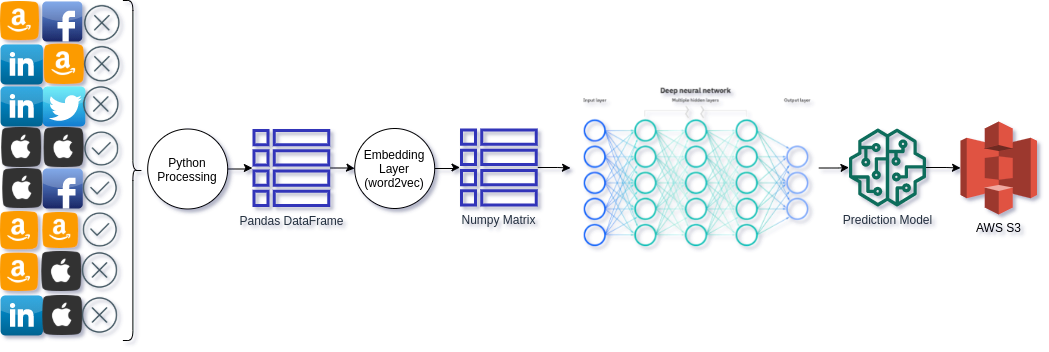

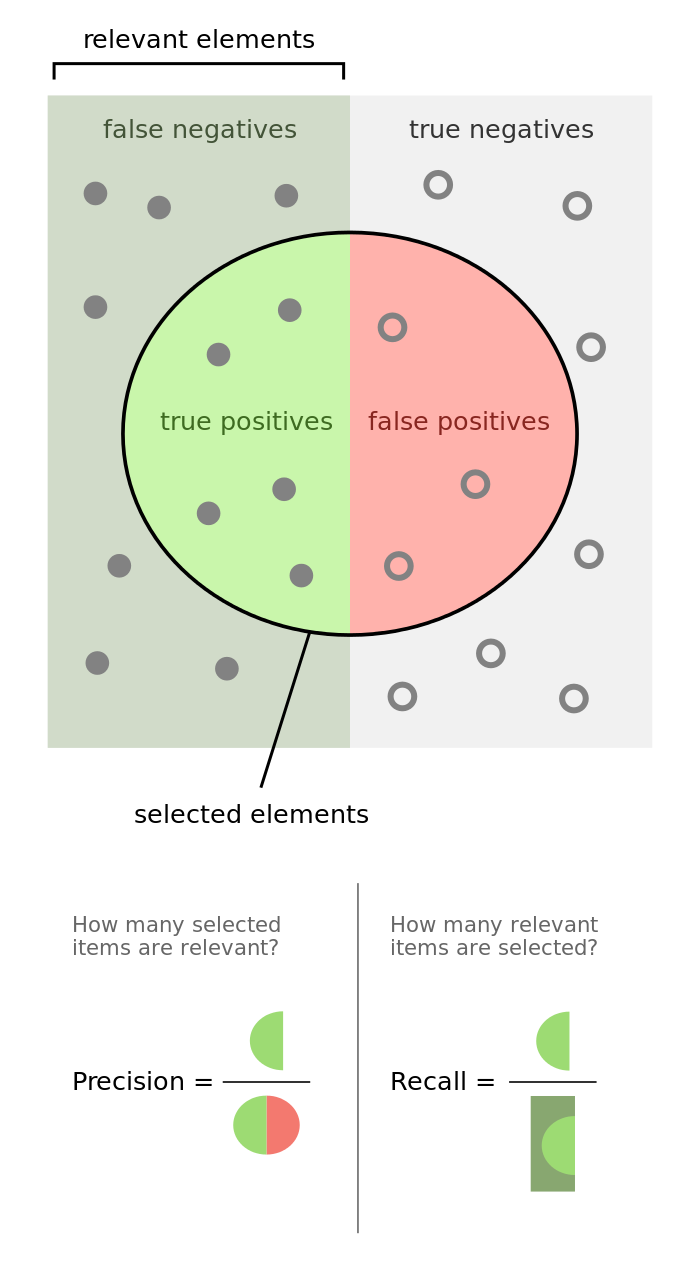

In [62]:
import csv 
import json
import string
import random
import typing

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
import keras
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# python3 -m spacy download en_core_web_sm
english: spacy.lang.en.English = spacy.load("en_core_web_sm")
    
np.random.seed(5)

In [3]:
def random_string(size: int = 10) -> str:
    """
    Generates a random string.
    """
    chars: str = string.ascii_lowercase + "aeiou" * 30 + "rtsmpcnlgr" * 15
    return "".join([
        random.choice(chars)
        for _ in range(size)
    ])

assert isinstance(random_string(), str)
assert random_string() != random_string()
assert len(random_string(10)) == 10
assert len(random_string(20)) == 20

In [4]:
def random_integer(low: int = 0, high: int = 100) -> int:
    """
    Generates a random integer.
    """
    return random.randint(low, high)

assert isinstance(random_integer(), int)
assert random_integer() >= 0
assert random_integer() <= 100
assert random_integer(low=120, high=140) >= 120
assert random_integer(low=120, high=140) <= 140

In [5]:
def random_float(low: int = 0, high: int = 100) -> float:
    """
    Generates a random float number.
    """
    return random.uniform(low, high)

assert isinstance(random_float(), float)
assert random_float() >= 0
assert random_float() <= 100
assert random_float(low=120, high=140) <= 140
assert random_float(low=120, high=140) >= 120

In [6]:
def random_probability() -> float:
    """
    Generates a random probability float number.
    """
    return random.uniform(0, 1)

assert isinstance(random_probability(), float)
assert random_probability() >= 0
assert random_probability() <= 1

In [7]:
def random_event(probability: float = 0.5) -> bool:
    """
    Generates a determines the occurrence of a random event.
    """
    assert probability >= 0
    assert probability <= 1
    return random_probability() < probability

assert isinstance(random_event(), bool)
assert random_event(probability=1) is True
assert random_event(probability=0) is False

In [8]:
def random_option(options: list) -> str:
    """
    Selects a value from a list randomly.
    """
    return random.choice(list(set(options)))

assert random_option([1, 2, 3]) in [1, 2, 3]

In [9]:
def random_phone() -> str:
    """
    Generates a random phone number.
    """
    return "-".join(
        [
            str(random_integer(100, 999)),
            str(random_integer(100, 999)),
            str(random_integer(1000, 9999)),
        ]
    )

assert isinstance(random_phone(), str)
assert random_phone() != random_phone()

In [10]:
def random_name() -> str:
    """
    Generates a random name.
    """
    return " ".join(
        [
            random_string(random_integer(8, 12)),
            random_string(random_integer(8, 12)),
        ]
    ).title()

assert isinstance(random_name(), str)
assert random_name() != random_name()

In [11]:
def random_city() -> str:
    """
    Generates a random city name.
    """
    return "".join(
        [
            random_string(random_integer(3, 6)),
            random_option([" ", ""]),
            random_string(random_integer(3, 6)),
        ]
    ).title()

assert isinstance(random_city(), str)
assert random_city() != random_city()

In [12]:
def random_website() -> str:
    """
    Generates a random website.
    """
    return ".".join(
        [
            "www",
            random_string(random_integer(7, 15)),
            random_option(["com", "net", "org"]),
        ]
    ).lower()

assert isinstance(random_website(), str)
assert random_website() != random_website()

In [13]:
def random_linkedin_url() -> str:
    """
    Generates a random LinkedIn URL.
    """
    return "/".join(
        [
            "www.linkedin.com",
            "u",
            random_string(random_integer(8, 15)),
        ]
    ).lower()

assert isinstance(random_linkedin_url(), str)
assert random_linkedin_url() != random_linkedin_url()

In [14]:
def random_facebook_url() -> str:
    """
    Generates a random Facebook URL.
    """
    return "/".join(
        [
            "https://",
            "www.facebook.com",
            "profile",
            random_string(random_integer(8, 15)),
        ]
    ).lower()

assert isinstance(random_facebook_url(), str)
assert random_facebook_url() != random_facebook_url()

In [15]:
def random_country() -> str:
    """
    Generates a random country.
    """
    return "".join(
        [
            random_string(random_integer(3, 6)),
            random_option([" ", ""]),
            random_string(random_integer(3, 6)),
        ]
    ).title()

assert isinstance(random_country(), str)
assert random_country() != random_country()

In [16]:
def random_street() -> str:
    """
    Generates a random street address.
    """
    return " ".join(
        [
            str(random_integer(1, 999)),
            random_string(random_integer(3, 8)),
            random_string(random_integer(4, 6)) + ",",
            random_string(random_integer(4, 6)),
            random_option(["St.", "Av."]),
        ]
    ).title()

assert isinstance(random_street(), str)
assert random_street() != random_street()

In [17]:
def similar_string(value: str, mutability: float = 0.2) -> str:
    """
    Generates a random string similar to a given string.
    """
    new_value: list = list(value)
    for i in range(len(new_value)):
        if random_event(mutability):
            new_value[i] = random_string(1)
    if new_value and random_event(mutability):
        new_value.pop(-1)
    if new_value and random_event(mutability):
        new_value.append(random_string(1))
    if not new_value and random_event(mutability):
        new_value: str = random_string(random_integer(4, 12))
    return "".join(new_value)

assert isinstance(similar_string("a", mutability=0.5), str)
assert similar_string("a", mutability=0.0) == "a"
assert similar_string("a", mutability=1.0) != "a"
assert similar_string("aaaaaa", mutability=1.0) != similar_string("aaaaaa", mutability=1)

In [18]:
def similar_dict(record: dict, mutability: float = 0.1) -> dict:
    """
    Generates a random dictionary similar to a given dictionary.
    """
    other: dict = {}
    for k, v in record.items():
        if isinstance(v, str):
            other[k] = similar_string(value=v, mutability=mutability)
        else:
            other[k] = v
    return other

assert isinstance(similar_dict({"a": "b"}, mutability=0.5), dict)
assert similar_dict({"a": "b"}, mutability=0.0) == {"a": "b"}
assert similar_dict({"a": "b"}, mutability=1.0) != {"a": "b"}

In [19]:
def random_company(nulls: float = 0.1) -> dict:
    """
    Generates a random dictionary representation of a company.
    """
    return {
        "city": "" if random_event(probability=nulls) else random_city(),
        "country": "" if random_event(probability=nulls) else random_country(),
        "company_name": random_name(),
        "phone": "" if random_event(probability=nulls) else random_phone(),
        "street_address": "" if random_event(probability=nulls) else random_street(),
        "website": "" if random_event(probability=nulls) else random_website(),
        "linkedin_url": "" if random_event(probability=nulls) else random_linkedin_url(),
        "facebook_url": "" if random_event(probability=nulls) else random_facebook_url(),
    }

assert isinstance(random_company(), dict)
assert all(isinstance(k, str) for k in random_company().keys())
assert all(isinstance(v, str) for v in random_company().values())

In [20]:
def random_person(nulls: float = 0.1) -> dict:
    """
    Generates a random representation of a person.
    """
    return {
        "city": "" if random_event(probability=nulls) else random_city(),
        "country": "" if random_event(probability=nulls) else random_country(),
        "name": random_name(),
        "phone": "" if random_event(probability=nulls) else random_phone(),
        "street_address": "" if random_event(probability=nulls) else random_street(),
        "linkedin_url": "" if random_event(probability=nulls) else random_linkedin_url(),
        "facebook_url": "" if random_event(probability=nulls) else random_facebook_url(),
    }

assert isinstance(random_person(), dict)
assert all(isinstance(k, str) for k in random_person().keys())
assert all(isinstance(v, str) for v in random_person().values())

In [21]:
def add_suffix(record: dict, suffix: str) -> dict:
    """
    Appends a suffix to all the keys of a given dictionary.
    """
    return {f"{k}#{suffix}": v for k, v in record.items()}

assert add_suffix({"a": "b"}, "1") == {"a#1": "b"}
assert add_suffix({"a": "b"}, "2") == {"a#2": "b"}

In [22]:
def word2vec(text: typing.Optional[str]) -> np.ndarray:
    """
    Transforms a string into a numpy array of a fixed size.
    """
    if not isinstance(text, str) or text == "":
        return np.zeros(96)
    return english(text).vector

assert isinstance(word2vec("lorem"), np.ndarray)
assert np.array_equal(word2vec("lorem"), word2vec("lorem"))
assert word2vec("lorem").shape == (96, )
assert isinstance(word2vec(""), np.ndarray)
assert np.array_equal(word2vec(""), word2vec(""))
assert word2vec("").shape == (96, )

In [23]:
def df2vec(dataset: pd.DataFrame, target: str = 'match') -> pd.DataFrame:
    """
    Transforms a string into a numpy array of a fixed size.
    """
    vectorized_dataset: pd.DataFrame = dataset.copy()  
    for feature in vectorized_dataset.columns:
        print("Vectorizing:", feature)
        if feature != target:
            vectorized_dataset[feature] = vectorized_dataset[feature].apply(word2vec).apply(np.array)
    return vectorized_dataset

assert isinstance(df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
)['a'][0], np.ndarray)
assert isinstance(df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
)['a'][1], np.ndarray)
assert df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
).shape == (2, 2)

Vectorizing: a
Vectorizing: t
Vectorizing: a
Vectorizing: t
Vectorizing: a
Vectorizing: t


Companies: (1, 17)
Companies: (1, 17)
Companies: (1, 17)
Companies: (1, 17)
Companies: (2, 17)


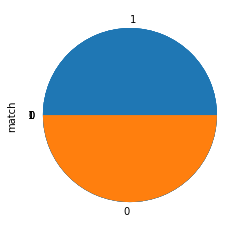

In [125]:
def generate_random_companies(
    total: int = 1000,
    target: str = 'match',
    matches: float = 0.5,
    nulls: float = 0.1,
    mutability: float = 0.01,
    feedback: list = None,
    relevance: int = 10,
) -> pd.DataFrame:
    """
    Generates a random dataset of $total companies.
    """
    raw_companies_list: typing.List[dict] = []
    for _ in range(total):
        company1: dict = random_company(nulls=nulls)
        if random_event(probability=matches):
            company2: dict = similar_dict(company1, mutability=mutability)
            match: str = "1" 
        else:
            company2: dict = random_company(nulls=0.1)
            match: str = "0" 
        row: dict = {}
        for k, v in add_suffix(company1, "1").items():
            row[k] = v 
        for k, v in add_suffix(company2, "2").items():
            row[k] = v 
        raw_companies_list.append({
            **add_suffix(company1, "1"),
            **add_suffix(company2, "2"),
            target: match,
        })
    if feedback is not None:
        for case in feedback:
            raw_companies_list.extend([{
                **add_suffix(case[0], "1"),
                **add_suffix(case[1], "2"),
                target: case[2],                
            }] * relevance)
    raw_companies_dataframe: pd.DataFrame = pd.DataFrame(raw_companies_list)
    raw_companies_dataframe[target] = raw_companies_dataframe[target].astype(int)
    print("Companies:", raw_companies_dataframe.shape)
    raw_companies_dataframe[target].astype(int).value_counts().plot(kind='pie')
    return raw_companies_dataframe

assert isinstance(generate_random_companies(total=1), pd.DataFrame)
assert not generate_random_companies(total=1).equals(generate_random_companies(total=1))
assert generate_random_companies(total=1).shape == (1, 17)
assert generate_random_companies(total=2).shape == (2, 17)

Persons: (1, 15)
Persons: (1, 15)
Persons: (1, 15)
Persons: (1, 15)
Persons: (2, 15)


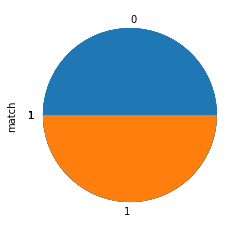

In [148]:
def generate_random_persons(
    total: int = 1000,
    target: str = 'match',
    matches: float = 0.5,
    nulls: float = 0.1,
    mutability: float = 0.01,
    feedback: list = None,
    relevance: int = 10,
) -> pd.DataFrame:
    """
    Generates a random dataset of $total persons.
    """
    raw_persons_list: typing.List[dict] = []
    for _ in range(total):
        person1: dict = random_person(nulls=nulls)
        if random_event(probability=matches):
            person2: dict = similar_dict(person1, mutability=mutability)
            match: str = "1" 
        else:
            person2: dict = random_person(nulls=0.1)
            match: str = "0" 
        row: dict = {}
        for k, v in add_suffix(person1, "1").items():
            row[k] = v 
        for k, v in add_suffix(person2, "2").items():
            row[k] = v 
        raw_persons_list.append({
            **add_suffix(person1, "1"),
            **add_suffix(person2, "2"),
            target: match,
        })
    if feedback is not None:
        for case in feedback:
            raw_persons_list.extend([{
                **add_suffix(case[0], "1"),
                **add_suffix(case[1], "2"),
                target: case[2],                
            }] * relevance)
    raw_persons_dataframe: pd.DataFrame = pd.DataFrame(raw_persons_list)
    raw_persons_dataframe[target] = raw_persons_dataframe[target].astype(int)
    print("Persons:", raw_persons_dataframe.shape)
    raw_persons_dataframe[target].astype(int).value_counts().plot(kind='pie')
    return raw_persons_dataframe

assert isinstance(generate_random_persons(total=1), pd.DataFrame)
assert not generate_random_persons(total=1).equals(generate_random_persons(total=1))
assert generate_random_persons(total=1).shape == (1, 15)
assert generate_random_persons(total=2).shape == (2, 15)

In [26]:
def vec2matrix(data: pd.DataFrame) -> np.ndarray:
    """
    Transforms a Pandas DataFrame into a Numpy 3D Array.
    """
    features: typing.List[np.ndarray] = []
    for feature in data.columns:
        features.append(np.array(data[feature].to_list()))
    matrix: np.array = np.array(features)
    matrix: np.array = np.swapaxes(matrix, 0, 1)
    return matrix

array: np.ndarray = np.zeros((3, ))
dataframe: pd.DataFrame = pd.DataFrame({"a": [array, array]})
assert vec2matrix(dataframe).shape == (2, 1, 3)

Predictors: ['a']
Predicted: m
X (20, 1)
Y (20,)
Train (12, 1) (12,)
Test (4, 1) (4,)
Val (4, 1) (4,)
Train: (12, 1, 3) (12,)
Test: (4, 1, 3) (4,)
Val: (4, 1, 3) (4,)
Matches: [6, 2, 2] [12, 4, 4]


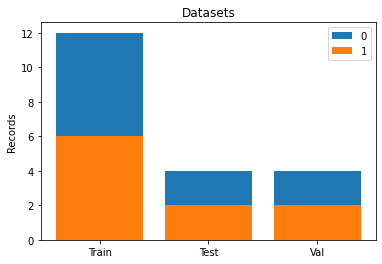

In [27]:
def split_dataframe(
    dataset: pd.DataFrame,
    target: str = 'match',
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 5,
) -> typing.Tuple[np.ndarray]:

    features = [column for column in dataset.columns if column != target]

    print("Predictors:", features)
    print("Predicted:", target)
    
    x: pd.DataFrame = dataset[features]
    y: pd.DataFrame = dataset[target]
    assert x.shape[0] == y.shape[0]
        
    print("X", x.shape)
    print("Y", y.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y,
    )
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=val_size,
        random_state=random_state,
        shuffle=True,
        stratify=y_train,
    )
    
    print("Train", x_train.shape, y_train.shape)
    print("Test", x_test.shape, y_test.shape)
    print("Val", x_val.shape, y_val.shape)

    assert x_train.shape[0] == y_train.shape[0]
    assert x_test.shape[0] == y_test.shape[0]
    assert x_val.shape[0] == y_val.shape[0]

    assert x_train.shape[1] == x_test.shape[1]
    assert x_train.shape[1] == x_val.shape[1]
    assert x_test.shape[1] == x_val.shape[1]

    assert x_train.shape[0] + x_test.shape[0] + x_val.shape[0] == x.shape[0]
    assert y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0]

    y_train: np.ndarray = y_train.values
    y_test: np.ndarray = y_test.values
    y_val: np.ndarray = y_val.values
    
    x_train: typing.List[np.array] = vec2matrix(x_train)
    x_test: typing.List[np.array] = vec2matrix(x_test)
    x_val: typing.List[np.array] = vec2matrix(x_val)

    print("Train:", x_train.shape, y_train.shape)
    print("Test:", x_test.shape, y_test.shape)
    print("Val:", x_val.shape, y_val.shape)
        
    matches: list = [
        sum(y_train == 1),
        sum(y_test == 1),
        sum(y_val == 1),   
    ]
    missmatches: list = [
        y_train.shape[0],
        y_test.shape[0],
        y_val.shape[0],   
    ]
    print("Matches:", matches, missmatches)
    assert matches != missmatches, "Too many matches!"
    assert all(matches), "Not enough matches!"
    assert all(missmatches), "Not enough missmatches!"
    labels: list = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots()
    ax.bar(labels, missmatches, label='0')
    ax.bar(labels, matches, label='1')
    ax.set_ylabel('Records')
    ax.set_title('Datasets')
    ax.legend()
    plt.show()
    
    return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(
    dataset=pd.DataFrame({"a": [np.array([1, 2, 3])] * 20, "m": [1, 0] * 10}),
    target='m',
    test_size=0.2,
    val_size=0.2,
)
assert x_train.shape == (12, 1, 3)
assert y_train.shape == (12, )
assert x_test.shape == (4, 1, 3)
assert y_test.shape == (4, )
assert x_val.shape == (4, 1, 3)
assert y_val.shape == (4, )
assert isinstance(x_train, np.ndarray)
assert isinstance(y_train, np.ndarray)
assert isinstance(x_test, np.ndarray)
assert isinstance(y_test, np.ndarray)
assert isinstance(x_val, np.ndarray)
assert isinstance(y_val, np.ndarray)

Input: (2, 2, 2)


2021-08-02 12:32:39.876062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-02 12:32:39.876093: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-02 12:32:39.876177: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LenovoX1Carbon): /proc/driver/nvidia/version does not exist
2021-08-02 12:32:39.876380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 2)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 4096)              20480     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              209817

2021-08-02 12:32:40.288838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-02 12:32:40.302275: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594095000 Hz


1/1 [==============================] - 13s 13s/step - loss: 0.7030 - binary_accuracy: 0.0000e+00 - val_loss: 6.6757 - val_binary_accuracy: 0.5000
{'loss': [0.7029697299003601], 'binary_accuracy': [0.0], 'val_loss': [6.675711154937744], 'val_binary_accuracy': [0.5]}


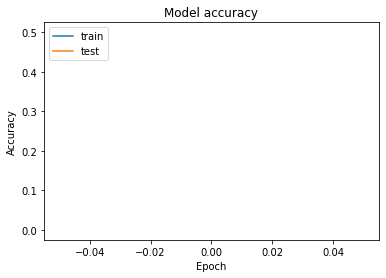

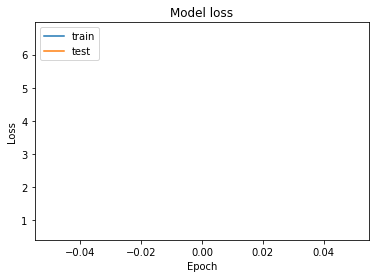

1/1 [==============================] - 0s 27ms/step - loss: 6.6757 - binary_accuracy: 0.5000
Metrics: 6.675711154937744 0.5


In [28]:
def train_find_matches(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    x_val: np.ndarray,
    y_val: np.ndarray,
    learning_rate: float = 0.0001,
    batch_size: int = 30,
    epochs: int = 1,
    dropout: float = 0.4,
) -> typing.Tuple[keras.models.Model, float, float]:
    """
    Trains a classifier to find matches.
    """
    print("Input:", x_train.shape)
    
    input_layer: keras.layers.Input = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    flatten: keras.layers.Flatten = keras.layers.Flatten()(input_layer)

    dense1: keras.layers.Dense = keras.layers.Dense(4096, activation='relu')(flatten)
    dropout1: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense1)

    dense2: keras.layers.Dense = keras.layers.Dense(2048, activation='relu')(dropout1)
    dropout2: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense2)

    dense3: keras.layers.Dense = keras.layers.Dense(1024, activation='relu')(dropout2)
    dropout3: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense3)

    dense4: keras.layers.Dense = keras.layers.Dense(514, activation='relu')(dropout3)
    dropout4: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense3)

    out: keras.layers.Dense = keras.layers.Dense(1, activation='sigmoid')(dropout4)

    model: keras.Model = keras.Model(inputs=[input_layer, ], outputs=out)

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy()
        ],
    )

    print(model.summary())
    
    history: keras.callbacks.History = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        ]
    )

    print(history.history)

    # Summarize history of accuracy.
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Summarize history for loss.
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    loss, accuracy = model.evaluate(x_val, y_val, batch_size=128)
    print("Metrics:", loss, accuracy)
    
    return model, loss, accuracy


x: np.array = np.array([[[0, 1], [0, 1]], [[0, 1], [0, 1]]])
y: np.array = np.array([0, 1])
sample_model, sample_loss, sample_accuracy = train_find_matches(
    x_train=x,
    y_train=y,
    x_test=x,
    y_test=y,
    x_val=x,
    y_val=y,
    epochs=1,
    learning_rate=0.01,
    batch_size=50,
)
assert isinstance(sample_model, keras.models.Model)
assert isinstance(sample_loss, float)
assert isinstance(sample_accuracy, float)

In [138]:
 def predict_find_matches(
    model: keras.models.Model,
    records: typing.Union[np.ndarray, list],
    confidence: typing.Optional = None,
 ) -> np.ndarray:
    """
    Uses a trained model to find matches.
    """
    if isinstance(records, list):
        records: np.ndarray = vec2matrix(df2vec(pd.DataFrame(data=records, columns=records[0].keys())))
    print("Input:", records.shape)
    predictions: list = model.predict(records)
    print("Predictions:", predictions)
    if confidence is not None:
        predictions = predictions >= confidence
        print("Confidence:", predictions)
    return predictions


assert predict_find_matches(model=sample_model, records=np.zeros((1, 2, 2))).shape == (1, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((2, 2, 2))).shape == (2, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((3, 2, 2))).shape == (3, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((1, 2, 2)), confidence=0)[0][0]

Input: (1, 2, 2)
Predictions: [[0.97551405]]
Input: (2, 2, 2)
Predictions: [[0.97551405]
 [0.97551405]]
Input: (3, 2, 2)
Predictions: [[0.9755141]
 [0.9755141]
 [0.9755141]]
Input: (1, 2, 2)
Predictions: [[0.97551405]]
Confidence: [[ True]]


/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00         1
        True       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



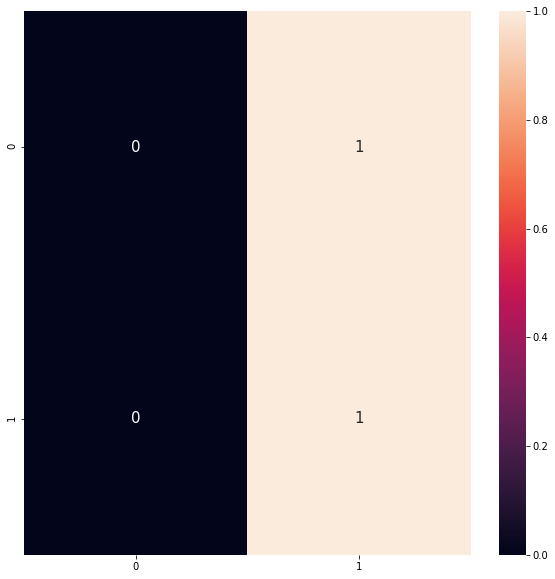

In [140]:
def error_analysis(
    model: keras.models.Model,
    x_test: np.array,
    y_test: np.array,
    confidence: float
) -> None:
    """
    Performs error analysis on a prediction model.
    """
    y_pred: np.ndarray = np.array(model.predict(x_test))
    matrix = confusion_matrix(y_test > confidence, y_pred > confidence)
    print(classification_report(y_test > confidence, y_pred > confidence))
    cm = confusion_matrix(y_test > confidence, y_pred > confidence)
    cm = pd.DataFrame(cm, range(2),range(2))
    plt.figure(figsize = (10,10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 15})
    plt.show()
    
assert error_analysis(
    model=sample_model,
    confidence=0.3,
    x_test=np.array([[[0, 1], [0, 1]], [[0, 1], [0, 1]]]),
    y_test=np.array([0, 1]),
) is None

# Companies Find Matches

Companies: (10000, 17)


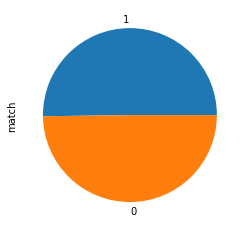

In [127]:
raw_companies_dataframe: pd.DataFrame = generate_random_companies(
    total=9900,
    nulls=.01,
    mutability=.01,
    matches=.5,
    relevance=50,
    feedback=[
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "company_name": "Airbnb",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "website": "www.airbnb.com",
                "linkedin_url": "https://www.linkedin.com/u/airbnb",
                "facebook_url": "https://www.facebook.com/user/airbnb",
            },
            {
                "city": "San Francisco",
                "country": "USA",
                "company_name": "airbnb",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "website": "www.airbnb.com.ar",
                "linkedin_url": "https://www.linkedin.com/u/airbnb",
                "facebook_url": "https://www.facebook.com/user/airbnb",
            },
            1
        ),
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "company_name": "Airbnb",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "website": "www.airbnb.com",
                "linkedin_url": "https://www.linkedin.com/u/airbnb",
                "facebook_url": "https://www.facebook.com/user/airbnb",
            },
            {
                "city": "Mexico",
                "country": "Mexico",
                "company_name": "Taco Bell",
                "phone": "543-543-1231",
                "street_address": "50 Something St.",
                "website": "www.taco-bell.com",
                "linkedin_url": "https://www.linkedin.com/u/taco",
                "facebook_url": "https://www.facebook.com/user/taco",  
            },
            0
        ),  
    ]
)

In [128]:
raw_companies_dataframe.head(10)

,city#1,country#1,company_name#1,phone#1,street_address#1,website#1,linkedin_url#1,facebook_url#1,city#2,country#2,company_name#2,phone#2,street_address#2,website#2,linkedin_url#2,facebook_url#2,match
0,Gmea Loaiom,Zierl Oaaw,Asugreileg Uncuooprgso,454-387-2793,"788 Aauocm Amoio, Cuuoec St.",www.retgioig.net,www.linkedin.com/u/keporploo,https:///www.facebook.com/profile/soepclteeo,Gmea Loaiom,Zierl Oaaw,Asugreileg Uncuooprgso,454-387-2793,"788 Aauocm Amoio, CuuoeclSt.",www.retgioig.net,www.linkedinacom/u/keporploo,https:///www.facebook.com/profile/soepclteeo,1
1,Pueomg Ric,Rputesoicoai,Riuaucitoi Ucrozrigelr,765-891-3829,"733 Unoor Rree, Irig St.",www.simaezuemogpu.com,www.linkedin.com/u/isjoeaii,https:///www.facebook.com/profile/gaicgpiarr,Pueomg Ric,Rputesoicoai,Riuaucitoi Ucrozrigelrc,765-891-3829,"733 Unoor Rree, Irig St.",www.simaezuemogpu.com,www.linaedin.com/u/isjoeaii,https:///www.facebook.com/profile/gaicgpiarr,1
2,Aeeupiiee,Uixo Eeac,Lljegrop Asoaurug,654-146-5629,"974 Grn Ouaeum, Sepru St.",www.cctissritoagegg.net,www.linkedin.com/u/rerpmalrr,https:///www.facebook.com/profile/seautguesvge,Iiuzsauloga,Ntrguu Aoromi,Moonrocn Rrlegais,466-938-6623,"46 Hmp Mnsf, Opvoep St.",www.usnoiue.org,www.linkedin.com/u/gtuccreiuu,https:///www.facebook.com/profile/ezmcrursuueee,0
3,Ymc Oanspa,Euaaim Cieo,Teoieglt Inaitsnerol,181-575-7745,"791 Eoaig Oeenl, Pmpeup Av.",www.aoceceslp.org,www.linkedin.com/u/ioorbcoeait,https:///www.facebook.com/profile/lilbecjgtnceeiu,Ymc Oanspa,Euaaim Cieo,Teoieglt Inaitsnerol,181-575-7745,"791 Eoaig Oeenl, Pmpeup Av.",www.aoceceslp.org,www.linkedin.com/u/ioorbcoeait,https:///www.facebook.com/profile/lilbecjgtnceeiu,1
4,Aso Ogao,Otiaepnas,Eeorpicg Aiiauirsurri,892-996-7926,"413 Caranmu Pirtt, Euma Av.",www.irlromdmmriu.org,www.linkedin.com/u/ggpuuteranop,https:///www.facebook.com/profile/gneoerin,Oiotoclm,Igoui Patal,Maepusesen Nuuielpp,706-721-8588,,www.eioimrumttsae.com,www.linkedin.com/u/acnopragei,https:///www.facebook.com/profile/treimara,0
5,Norea Ouloo,Rrzm Lpln,Moetoseusrpf Gktjcuoe,106-840-9451,"214 Ieirta Neuuep, Nceo Av.",www.agnaarimoaozp.net,www.linkedin.com/u/ceeuimorepsro,https:///www.facebook.com/profile/qtausuaciegit,Norea Ouloo,Rrzm Lpln,Moetoseusrpf Gktjcuoe,106-840-9451,"214 Ieirta Neuuep, Nceo Av.",www.agnaarimoaozp.net,www.linkedin.com/u/ceeuimorepsro,https:///www.facebook.com/profile/qtausuaciegit,1
6,Slaeeluu,Aausrnpo,Arcopuio Roonmtasce,543-946-8389,"655 Uea Pertnr, Uage St.",www.iaeaerrmuulvuin.org,www.linkedin.com/u/eciggoietm,https:///www.facebook.com/profile/goeoeesoonerae,Slaeeluu,Aausunpo,Arcopuio Rooomtasce,543-946-8389,"655 Uea Pertnr, Uage St.",www.iaeaerrmuulvuin.org,www.linkedin.com/u/ecrggoietm,https:///www.facebook.com/profile/goeoeesoonerae,1
7,Pnulesolo,Aumoonec,Hccfrieulnms Oupeiuvmeurn,437-897-1683,"755 Aaoiaar Meee, Uaoi Av.",www.uermlpsiolgpu.net,www.linkedin.com/u/ggiyppcsanmroum,https:///www.facebook.com/profile/cgnrouirseaenen,Pnulesolo,Aumoonec,Hccfrieulnms Oupeiuvmeurn,437-897-1683,"755 Aaoiaar Meee, Uaoi Av.",www.uermlssiolgpu.net,www.linkedin.com/u/ggiyppcsanmroum,https:///www.facebook.com/profile/cgnrouirseaenen,1
8,Emt Uap,Mlra Spe,Rilnotlrn Nlduacau,773-644-6572,"787 Ucf Ntid, Orsri St.",www.isulopparmtmn.org,www.linkedin.com/u/eiuaiogolprtgup,https:///www.facebook.com/profile/rumiingotieee,Giiuorno,Ieugausooo,Iluocela Onurugsugu,,"202 Rceiraec Ruta, Llcou Av.",www.auiignrnthr.com,www.linkedin.com/u/oreiragauotgme,https:///www.facebook.com/profile/naocccuoulns,0
9,Plgsmoao,Eaocriniocgu,Tramturnape Ueunygiirmro,700-269-4169,"495 Til Tocur, Eoiuc St.",www.aoratlibmiera.net,www.linkedin.com/u/oaanunuaslaaaau,https:///www.facebook.com/profile/aptodonmo,Uorm Smors,Gcpo Ertrcr,Oiaqsrfg Oruplarr,349-431-1318,"639 Opis Rrniut, Sireuo Av.",www.ueuciorourve.com,www.linkedin.com/u/lgeuearun,,0


In [129]:
vectorized_companies_dataframe: pd.DataFrame = df2vec(raw_companies_dataframe)

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: company_name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: website#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: company_name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: website#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Vectorizing: match


In [130]:
vectorized_companies_dataframe.head(10)

,city#1,country#1,company_name#1,phone#1,street_address#1,website#1,linkedin_url#1,facebook_url#1,city#2,country#2,company_name#2,phone#2,street_address#2,website#2,linkedin_url#2,facebook_url#2,match
0,"[-0.17081124, -0.64723957, 0.22311965, 0.11456...","[-0.1733922, -0.29064077, 0.08646101, 0.469208...","[-0.2278746, -0.33084768, -0.6021811, 0.147618...","[0.1663901, 0.4832298, 0.31022692, -0.52979314...","[0.13965015, -0.3673879, 0.4392662, -0.1811918...","[0.8729764, -0.21711689, 0.14693439, 0.1163865...","[0.30312464, -0.3625717, 0.23163374, 0.4615468...","[0.37542623, 0.53012043, 0.40159354, -0.314179...","[-0.17081124, -0.64723957, 0.22311965, 0.11456...","[-0.1733922, -0.29064077, 0.08646101, 0.469208...","[-0.2278746, -0.33084768, -0.6021811, 0.147618...","[0.1663901, 0.4832298, 0.31022692, -0.52979314...","[0.054061692, -0.09831729, 0.62615895, 0.04232...","[0.8729764, -0.21711689, 0.14693439, 0.1163865...","[-0.35564625, 0.0014702752, -0.2596981, -0.141...","[0.37542623, 0.53012043, 0.40159354, -0.314179...",1
1,"[0.28466508, -0.6870391, 0.034863576, 0.143425...","[-0.45580024, -0.64020044, -0.94991213, 1.1212...","[-0.077516824, -0.10479821, 0.33265123, -0.063...","[0.10064737, 0.48980132, 0.121493064, -0.52424...","[-0.10337315, -0.25847742, 0.5891691, -0.21212...","[0.01968214, 0.6168068, -0.90221906, 0.0048712...","[-0.456138, -0.53931075, -0.30390802, 0.474316...","[0.21144052, 0.20298834, 0.21815896, -0.486129...","[0.28466508, -0.6870391, 0.034863576, 0.143425...","[-0.45580024, -0.64020044, -0.94991213, 1.1212...","[-0.3959472, -0.06375926, 0.039568715, 0.15786...","[0.10064737, 0.48980132, 0.121493064, -0.52424...","[-0.10337315, -0.25847742, 0.5891691, -0.21212...","[0.01968214, 0.6168068, -0.90221906, 0.0048712...","[-0.6107266, -1.229, 0.017428547, -0.58206856,...","[0.21144052, 0.20298834, 0.21815896, -0.486129...",1
2,"[0.008446187, -0.89799815, 0.3153159, -0.01146...","[-0.08009297, -0.70065546, 0.8756641, -0.21270...","[-0.05640249, -0.50657225, 0.198513, 0.1292749...","[0.22372286, 0.7134844, 0.27984577, -0.703583,...","[-0.26451614, -0.3932885, 0.4730599, -0.185341...","[0.19262332, -0.031438783, -0.19407359, 0.1009...","[-0.28189784, -0.4292636, 0.48723325, -0.07348...","[0.5606265, 0.4351116, 0.43130416, -0.25141925...","[-0.21692994, -0.59062845, -0.63720477, 0.0989...","[-0.2784196, -0.5214716, -0.2022338, 0.1992558...","[-0.05473563, -0.11676584, 0.12873732, -0.0655...","[0.12499511, 0.7256371, 0.2397831, -0.56979215...","[-0.23111165, -0.4517533, 0.1346171, -0.219431...","[0.0700393, -0.6345332, 0.08723115, 0.00782650...","[0.3146601, -0.14218765, 0.77169657, -0.107591...","[0.533215, 0.30011246, 0.2952332, -0.20062599,...",0
3,"[0.4621147, -0.32601243, 0.14875361, 0.0588712...","[-0.17904884, -0.30857, -0.08816792, 0.2628701...","[0.3672084, -0.39905167, 0.45736057, -0.170849...","[0.15963465, 0.23201807, 0.07888236, -0.746187...","[-0.27435634, -0.34182993, 0.42234477, -0.0363...","[-0.8862241, -0.77771133, -0.3682679, -0.15156...","[-0.24318284, -1.1066128, -0.28148663, -0.1359...","[0.3766895, 0.3671902, 0.2224524, -0.2929603, ...","[0.4621147, -0.32601243, 0.14875361, 0.0588712...","[-0.17904884, -0.30857, -0.08816792, 0.2628701...","[0.3672084, -0.39905167, 0.45736057, -0.170849...","[0.15963465, 0.23201807, 0.07888236, -0.746187...","[-0.27435634, -0.34182993, 0.42234477, -0.0363...","[-0.8862241, -0.77771133, -0.3682679, -0.15156...","[-0.24318284, -1.1066128, -0.28148663, -0.1359...","[0.3766895, 0.3671902, 0.2224524, -0.2929603, ...",1
4,"[-0.01027973, -0.5219526, 0.10329938, -0.09050...","[-0.45395166, -0.35621172, -0.22584479, -0.092...","[-0.2773134, -0.9491745, 0.41337347, -0.102893...","[0.08987117, 0.77899325, 0.32785872, -0.414579...","[-0.18151264, -0.15535061, 0.33438784, 0.08275...","[-0.4375131, -0.1936216, 0.03947416, -0.094286...","[0.48783925, 0.17583346, -0.14498003, -0.67800...","[0.42487782, 0.26128945, 0.3736353, -0.1579544...","[-0.6800742, -0.19899178, 0.8965055,

Predictors: ['city#1', 'country#1', 'company_name#1', 'phone#1', 'street_address#1', 'website#1', 'linkedin_url#1', 'facebook_url#1', 'city#2', 'country#2', 'company_name#2', 'phone#2', 'street_address#2', 'website#2', 'linkedin_url#2', 'facebook_url#2']
Predicted: match
X (10000, 16)
Y (10000,)
Train (7200, 16) (7200,)
Test (2000, 16) (2000,)
Val (800, 16) (800,)
Train: (7200, 16, 96) (7200,)
Test: (2000, 16, 96) (2000,)
Val: (800, 16, 96) (800,)
Matches: [3616, 1004, 402] [7200, 2000, 800]


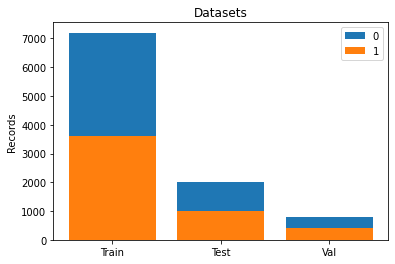

In [131]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(
    dataset=vectorized_companies_dataframe,
    test_size=0.2,
    val_size=0.1
)

Input: (7200, 16, 96)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 16, 96)]          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 4096)              6295552   
_________________________________________________________________
dropout_28 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_29 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 1

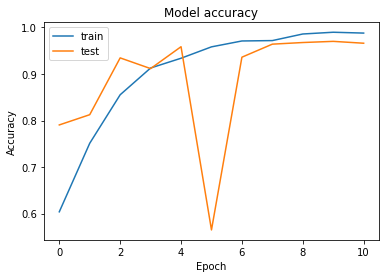

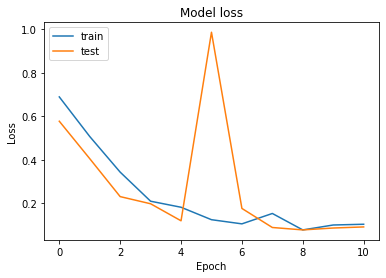

7/7 [==============================] - 2s 159ms/step - loss: 0.0612 - binary_accuracy: 0.9787
Metrics: 0.06116773933172226 0.9787499904632568


In [132]:
company_matches_model, loss, accuracy = train_find_matches(
    x_train,
    y_train,
    x_test,
    y_test,
    x_val,
    y_val,
    learning_rate=0.0001,
    epochs=11,
    batch_size=100,
    dropout=0.02,
)

In pattern recognition, information retrieval and classification (machine learning), precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved.

              precision    recall  f1-score   support

       False       0.96      0.97      0.97       996
        True       0.97      0.96      0.97      1004

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



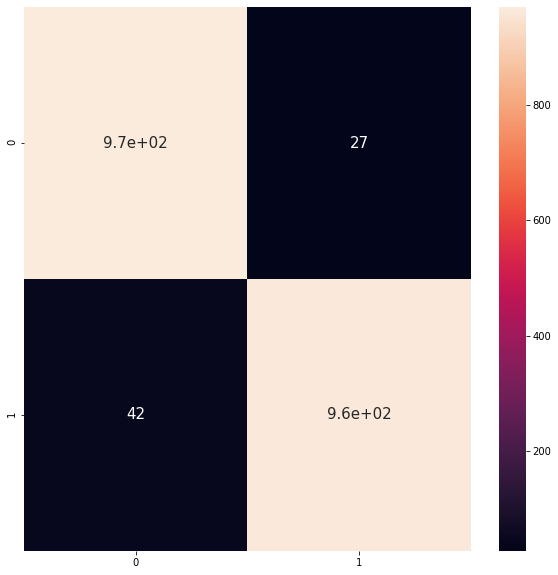

In [141]:
error_analysis(
    model=company_matches_model,
    confidence=0.9,
    x_test=x_test,
    y_test=y_test,
)

In [163]:
predictions: list = predict_find_matches(
    model=company_matches_model, 
    records=[{
        # Company 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "company_name#1": "Airbnb",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "website#1": "www.airbnb.com",
        "linkedin_url#1": "https://www.linkedin.com/u/airbnb",
        "facebook_url#1": "https://www.facebook.com/user/airbnb",
        # Company 2
        "city#2": "San Francisco",
        "country#2": "USA",
        "company_name#2": "Airbnb Inc.",
        "phone#2": "120-403-4032",
        "street_address#2": "960 Air Ave.",
        "website#2": "www.airbnb.com",
        "linkedin_url#2": "https://www.linkedin.com/u/airbnb",
        "facebook_url#2": "https://www.facebook.com/user/airbnb",
    }, {
        # Company 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "company_name#1": "Airbnb",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "website#1": "www.airbnb.com",
        "linkedin_url#1": "https://www.linkedin.com/u/airbnb",
        "facebook_url#1": "https://www.facebook.com/user/airbnb",
        # Company 2
        "city#2": "Mexico",
        "country#2": "Mexico",
        "company_name#2": "Taco Bell",
        "phone#2": "543-543-1231",
        "street_address#2": "50 Something St.",
        "website#2": "www.taco-bell.com",
        "linkedin_url#2": "https://www.linkedin.com/u/taco",
        "facebook_url#2": "https://www.facebook.com/user/taco",
    }, {
        # Company 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "company_name#1": "Airbnb",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "website#1": "www.airbnb.com",
        "linkedin_url#1": "https://www.linkedin.com/u/airbnb",
        "facebook_url#1": "https://www.facebook.com/user/airbnb",
        # Company 2
        "city#2": "Canada",
        "country#2": "Canada",
        "company_name#2": "McDonalds",
        "phone#2": "432-435-6539",
        "street_address#2": "43 Other Av.",
        "website#2": "www.mcdonalds.com",
        "linkedin_url#2": "https://www.linkedin.com/u/mcdonalds",
        "facebook_url#2": "https://www.facebook.com/user/mcdonalds",   
    }],
    confidence=0.99,
)
assert predictions[0][0]
assert not predictions[1][0]
assert not predictions[2][0]

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: company_name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: website#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: company_name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: website#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Input: (3, 16, 96)
Predictions: [[9.9999797e-01]
 [1.5853679e-13]
 [1.5527898e-09]]
Confidence: [[ True]
 [False]
 [False]]


# Persons Find Matches

Persons: (10000, 15)


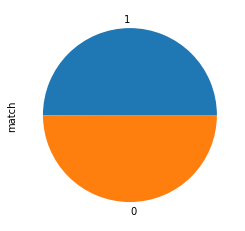

In [172]:
raw_persons_dataframe: pd.DataFrame = generate_random_persons(
    total=9900,
    nulls=.01,
    mutability=.01,
    matches=.5,
    relevance=50,
    feedback=[
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "name": "John Connor",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "linkedin_url": "https://www.linkedin.com/u/john.connor",
                "facebook_url": "https://www.facebook.com/user/john.connor",
            },
            {
                "city": "San Francisco",
                "country": "USA",
                "name": "John Conor",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "linkedin_url": "https://www.linkedin.com/u/john.connor",
                "facebook_url": "https://www.facebook.com/user/john.connor",
            },
            1
        ),
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "name": "John Connor",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "linkedin_url": "https://www.linkedin.com/u/john.connor",
                "facebook_url": "https://www.facebook.com/user/john.connor",
            },
            {
                "city": "Los Angeles",
                "country": "USA",
                "name": "Sarah Connor",
                "phone": "230-304-4322",
                "street_address": "234 Water St.",
                "linkedin_url": "https://www.linkedin.com/u/sarah.connor",
                "facebook_url": "https://www.facebook.com/user/sarah.connor",
            },
            0
        ),
    ]
)

In [173]:
raw_persons_dataframe.head(10)

,city#1,country#1,name#1,phone#1,street_address#1,linkedin_url#1,facebook_url#1,city#2,country#2,name#2,phone#2,street_address#2,linkedin_url#2,facebook_url#2,match
0,,Tier Crl,Lcenaueta Gseilmsr,815-637-3817,"857 Loeoio Aouicl, Flizaw Av.",www.linkedin.com/u/ouenorra,https:///www.facebook.com/profile/ignsnmeerc,Gopalpuu,,Usetnsnenosl Ipgogpclimm,814-431-3632,"768 Gwamnpi Oeoe, Smsir Av.",,https:///www.facebook.com/profile/iaergiearorouac,0
1,Xboomtti,Udiispn,Oaaeunmeoa Ruueoccrr,630-744-5638,"977 Gieiar Nilu, Rssutp St.",www.linkedin.com/u/bhrlmlonrucc,https:///www.facebook.com/profile/iujgopmosgr,Xboomtti,Udiispn,Oaaeunmeoa Ruueoccrr,630-744-5638,"977 Gieiar Nilu, Rssutp St.",www.linkedis.com/u/bhrlmlonruccg,https:///www.facebook.com/profile/iujgopmosgr,1
2,,Annm Ipeu,Omrlgsuso Gmoensagaga,562-815-1012,"25 Lpoemiou Ogsote, Aatigc St.",www.linkedin.com/u/potucoioioerakn,https:///www.facebook.com/profile/rootnrrea,Couli Ieo,Euoruknolop,Eaoejissuueo Algtcarl,267-867-6615,"166 Lgieoi Gtrour, Trrumo Av.",www.linkedin.com/u/ltntscrnmsipat,https:///www.facebook.com/profile/roaitamiticioi,0
3,Ggti Emaso,Tgeooagle,Iaaconmu Mriuiealsoum,785-109-8185,"995 Oaceta Matfor, Rstr St.",www.linkedin.com/u/aeneormtougbiu,https:///www.facebook.com/profile/eealcpoc,Weldca,Opacioisoe,Avuwrripuk Slbaameai,474-219-1018,"944 Isamlmmu Rnea, Nmofni Av.",,https:///www.facebook.com/profile/imeeemcimo,0
4,Oonioi Omadr,Uuucrarioy,Iccmelufce Ioiirneiuiec,511-342-3689,"524 Acuoa Sogn, Amors Av.",www.linkedin.com/u/aoiihmigoeorona,https:///www.facebook.com/profile/aeroniun,Oonioi Omadr,Uuucrarioy,Iccmelufce Ioinrneiuiec,511-342-3689,"524 Acuoa Sogn, Amors Av.",www.linkedin.com/u/aoiihmigoeorona,httls:o//www.facebook.com/profile/aeroniun,1
5,Ipntgr Auteo,Uomscg Stsgit,Rgmuescguo Josgvcrcs,105-379-5222,"876 Unair Ueaou, Ottpza Av.",www.linkedin.com/u/ofumigrlusar,https:///www.facebook.com/profile/hlitgsetmonii,Ipntgr Auteo,Uomscg Stsgit,Rgmuescguo Josgvcrcs,105-379-5222,"876 Unair Ueaou, Ottpza Av.",www.linkedin.com/u/ofumigrlusar,https:///www.facebook.com/profile/hlitgsetmonii,1
6,Urr Insatp,Roxn Ueo,Iclgbprpir Lromgonoeeae,833-460-2624,"632 Sromg Uieor, Iila Av.",www.linkedin.com/u/iroaaeotlu,https:///www.facebook.com/profile/gtsuusnuenii,Eos Ovwc,,Pgsnuera Erukuoetg,835-946-6096,"646 Srslg Teuutm, Giosae Av.",www.linkedin.com/u/umrnlssoe,https:///www.facebook.com/profile/cungcctgpooitns,0
7,Pin Aci,Rozil Aoraao,Ictioecrencu Comnlagt,386-628-3174,"522 Tmqlda Uiacu, Glaom St.",www.linkedin.com/u/lnumlaiic,https:///www.facebook.com/profile/couuasre,Uucrt Mnmica,Rrsrproir,Eimuaitgar Egseisrpii,367-236-4533,"193 Taimsetu Pieg, Lonrc St.",www.linkedin.com/u/sioriaro,https:///www.facebook.com/profile/eierrolatem,0
8,Larai Rarant,Romr Lga,Lauenutpmars Csrtcngiorep,282-415-4632,"784 Rpoplls Etrmcm, Ueoian Av.",www.linkedin.com/u/rgoaoeleu,https:///www.facebook.com/profile/egrcmrtaenepao,Emi Inimla,,Lrlcsarcpm Amniergpmr,964-182-2215,,,https:///www.facebook.com/profile/gratpoaeg,0
9,Gmaouaiuuor,Aso Unip,Uhacorclje Aogiiarotgls,765-434-4144,"40 Noe Tiusue, Iomulu St.",www.linkedin.com/u/pliicinpptir,https:///www.facebook.com/profile/uullineitrgsme,Gmaouaiuuor,Aso Unip,Uhacorclja Aoginarotgls,765-434-4144,"40 Noe Tiusue, Iomulu St.",www.linkedin.com/u/pliicinpptir,https:///www.facebook.com/profile/uullineitrgsle,1


In [174]:
vectorized_persons_dataframe: pd.DataFrame = df2vec(raw_persons_dataframe)

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Vectorizing: match


In [175]:
vectorized_persons_dataframe.head(10)

,city#1,country#1,name#1,phone#1,street_address#1,linkedin_url#1,facebook_url#1,city#2,country#2,name#2,phone#2,street_address#2,linkedin_url#2,facebook_url#2,match
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.33806208, 0.086895615, 0.116224825, 0.0618...","[-0.34933227, -0.2106205, -0.1360507, 0.038428...","[0.16887774, 0.65122426, 0.19989617, -0.784912...","[-0.2289451, -0.44226894, 0.35295358, -0.10167...","[-0.71778774, -0.6098328, -0.13922524, -0.4531...","[0.48291373, 0.19668448, 0.58630955, -0.184213...","[-0.28951976, -0.5956406, -0.18228978, 0.19732...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.06459761, -0.7431905, 0.33501643, 0.417832...","[0.10370531, 0.4567527, 0.1802727, -0.5701315,...","[-0.33848244, -0.3047452, 0.13612664, 0.013021...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.56222314, 0.2046036, 0.3803789, -0.24411993...",0
1,"[-0.80358577, -0.82671404, -0.37399483, 0.0263...","[0.1924375, -0.7932594, 0.5277333, 0.054435894...","[-0.15253712, -0.76584876, 0.40635836, 0.20158...","[0.06750767, 0.63540876, 0.24815121, -0.871682...","[-0.3043956, -0.15834653, 0.4382156, -0.308350...","[0.4694089, -0.11895573, 0.23903382, -0.576898...","[0.39928356, 0.3982561, 0.3712339, -0.10306541...","[-0.80358577, -0.82671404, -0.37399483, 0.0263...","[0.1924375, -0.7932594, 0.5277333, 0.054435894...","[-0.15253712, -0.76584876, 0.40635836, 0.20158...","[0.06750767, 0.63540876, 0.24815121, -0.871682...","[-0.3043956, -0.15834653, 0.4382156, -0.308350...","[0.5952095, -0.89793414, -0.43667608, -0.36790...","[0.39928356, 0.3982561, 0.3712339, -0.10306541...",1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08995758, -0.44443446, 0.9511595, -0.394787...","[-0.13928975, -0.27118108, 0.17542964, 0.12549...","[0.17750491, 0.29854736, 0.18376015, -0.653003...","[-0.05129221, -0.254079, 0.23716325, -0.160038...","[0.1709955, -0.5495266, -0.15206802, -0.385299...","[0.17216352, 0.3157959, 0.34098616, -0.2978202...","[0.16284096, -0.5654431, 0.1832442, 0.05119581...","[-0.36701265, -0.6110436, -0.31378126, -0.1317...","[-0.21349409, -0.47541454, 0.4256311, 0.051735...","[0.42300138, 0.6515244, 0.30562407, -0.6020454...","[-0.1127262, -0.2523224, 0.4268349, -0.0037642...","[0.27468294, -0.42466375, 0.27251393, -0.02946...","[0.42491132, 0.378892, 0.17448303, -0.22951539...",0
3,"[-0.03747105, -0.64545083, 0.45971423, -0.1361...","[-0.019605681, -0.52111864, -0.82023907, -0.24...","[0.0845055, -0.41557404, 0.23800759, -0.101001...","[0.104056105, 0.7275071, 0.08199444, -0.666919...","[0.06518493, -0.62061125, 0.16085462, -0.28852...","[-0.3498528, -0.6881462, -0.28281814, 0.108114...","[0.4320628, 0.48924857, 0.13128908, -0.2300279...","[-0.46792638, -0.75368106, -1.0384717, -0.3422...","[-0.2539997, -0.29880625, 0.3714609, -0.202027...","[0.43388075, -0.3060286, 0.3854429, 0.02821834...","[0.35702285, 0.2852614, 0.35552317, -0.7096885...","[-0.16640346, -0.29747316, 0.58952004, 0.01931...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.30283895, 0.42740172, 0.29458892, -0.142781...",0
4,"[0.34219104, -0.22272833, 0.29944885, 0.224598...","[-0.3439262, -0.62242496, -0.5250815, -0.03490...","[-0.046257228, 0.28269833, -0.03186041, 0.3358...","[0.37935656, 0.5592426, 0.43632874, -0.7491644...","[-0.1519582, -0.25960264, 0.5826453, 0.0145043...","[-0.16140854, -0.4845662, -0.042230137, -0.713...","[0.37973335, 0.3609019, 0.14084454, -0.1895739...","[0.34219104, -0.22272833, 0.29944885, 0.224598...","[-0.3439262, -0.62242496, -0.5250815, -0.03490...","[-0.01973866, 0.15516709, -0.04195468, 0.02686...","[0.37935656, 0.5592426, 0.43632874, -0.7491644...","[-0.1519582, -0.25960264, 0.5826453, 0.0145043...","[-0.16140854, -0.4845662, -0.042230137, -0.713...","[0.021800702, 0.14864485, 0.5057089, -0.278883...",1
5,"[-0.04819388, -0.47787336, 0.07228744, 0.47974...","[0.3513934, -0.8199316, -0.15960664, 0.2498603...","[-0.071127236, -0.6470745, 0.36597723, 0.26762...","[0.23022214, 0.6

Predictors: ['city#1', 'country#1', 'name#1', 'phone#1', 'street_address#1', 'linkedin_url#1', 'facebook_url#1', 'city#2', 'country#2', 'name#2', 'phone#2', 'street_address#2', 'linkedin_url#2', 'facebook_url#2']
Predicted: match
X (10000, 14)
Y (10000,)
Train (6400, 14) (6400,)
Test (2000, 14) (2000,)
Val (1600, 14) (1600,)
Train: (6400, 14, 96) (6400,)
Test: (2000, 14, 96) (2000,)
Val: (1600, 14, 96) (1600,)
Matches: [3202, 1001, 800] [6400, 2000, 1600]


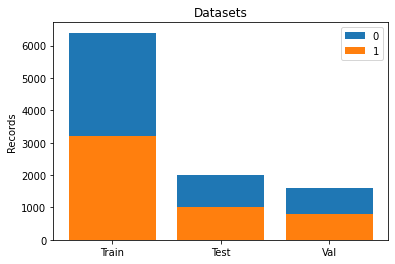

In [176]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(dataset=vectorized_persons_dataframe)

Input: (6400, 14, 96)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 14, 96)]          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 4096)              5509120   
_________________________________________________________________
dropout_44 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_45 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 

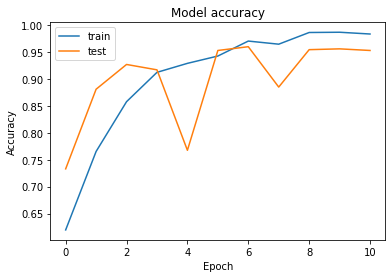

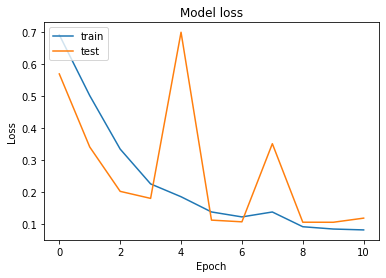

13/13 [==============================] - 2s 85ms/step - loss: 0.1154 - binary_accuracy: 0.9531
Metrics: 0.11536917835474014 0.953125


In [177]:
persons_matches_model, loss, accuracy = train_find_matches(
    x_train,
    y_train,
    x_test,
    y_test,
    x_val,
    y_val,
    learning_rate=0.0001,
    epochs=11,
    batch_size=100,
    dropout=0.01,
)

              precision    recall  f1-score   support

       False       0.96      0.97      0.97       999
        True       0.97      0.96      0.97      1001

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



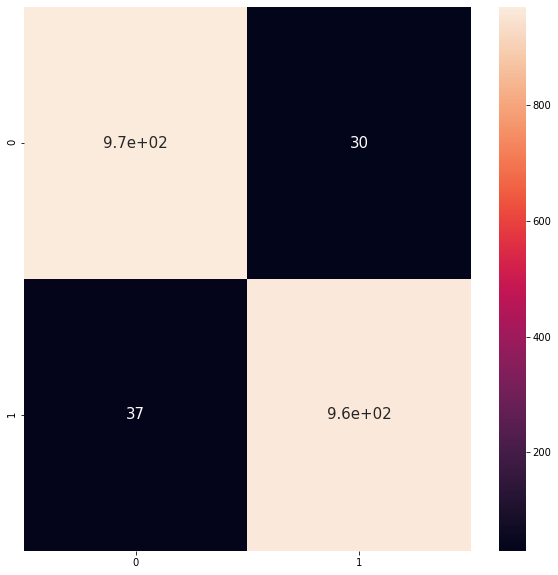

In [178]:
error_analysis(
    model=persons_matches_model,
    confidence=0.9,
    x_test=x_test,
    y_test=y_test,
)

In [182]:
predictions: list = predict_find_matches(
    model=persons_matches_model, 
    records=[{
        # Person 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "name#1": "John Connor",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "linkedin_url#1": "https://www.linkedin.com/u/john.connor",
        "facebook_url#1": "https://www.facebook.com/user/john.connor",
        # Person 2
        "city#2": "San Francisco",
        "country#2": "USA",
        "name#2": "John Conor",
        "phone#2": "120-403-4032",
        "street_address#2": "960 Air Ave.",
        "linkedin_url#2": "https://www.linkedin.com/u/john.connor",
        "facebook_url#2": "https://www.facebook.com/user/john.connor",
    }, {
        # Person 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "name#1": "John Connor",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "linkedin_url#1": "https://www.linkedin.com/u/john.connor",
        "facebook_url#1": "https://www.facebook.com/user/john.connor",
        # Person 2
        "city#2": "Mexico",
        "country#2": "Mexico",
        "name#2": "Terminator",
        "phone#2": "543-342-9594",
        "street_address#2": "120 Terminator St.",
        "linkedin_url#2": "https://www.linkedin.com/u/terminator",
        "facebook_url#2": "https://www.facebook.com/user/terminator",    
    }, {
        # Person 1
        "city#1": "Rosario",
        "country#1": "Argentina",
        "name#1": "Leo Celis",
        "phone#1": "443-223-4423",
        "street_address#1": "143 Nisman St.",
        "linkedin_url#1": "https://www.linkedin.com/u/leo.celis",
        "facebook_url#1": "https://www.facebook.com/user/leo.celis",
        # Person 2
        "city#2": "Rosario",
        "country#2": "Argentina",
        "name#2": "Leonardo Celis",
        "phone#2": "543-342-9594",
        "street_address#2": "142 Nisman Street",
        "linkedin_url#2": "https://www.linkedin.com/u/leo.celis",
        "facebook_url#2": "https://www.facebook.com/user/leo.celis",
    }, {
        # Person 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "name#1": "John Connor",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "linkedin_url#1": "https://www.linkedin.com/u/john.connor",
        "facebook_url#1": "https://www.facebook.com/user/john.connor",
        # Person 2
        "city#2": "Rosario",
        "country#2": "Argentina",
        "name#2": "Leonardo Celis",
        "phone#2": "543-342-9594",
        "street_address#2": "142 Nisman Street",
        "linkedin_url#2": "https://www.linkedin.com/u/leo.celis",
        "facebook_url#2": "https://www.facebook.com/user/leo.celis",
    }],
    confidence=0.9,
)
assert predictions[0][0]
assert not predictions[1][0]
assert predictions[2][0]
assert not predictions[3][0]

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Input: (4, 14, 96)
Predictions: [[9.9999774e-01]
 [8.2073718e-01]
 [9.9999374e-01]
 [1.4853030e-05]]
Confidence: [[ True]
 [False]
 [ True]
 [False]]
